# Finetuning a language model

<!--- @wandbcode{dlai_05} -->

Let's see how to finetune a language model to generate character backstories using HuggingFace Trainer with wandb integration. We'll use a tiny language model (`TinyStories-33M`) due to resource constraints, but the lessons you learn here should be applicable to large models too!

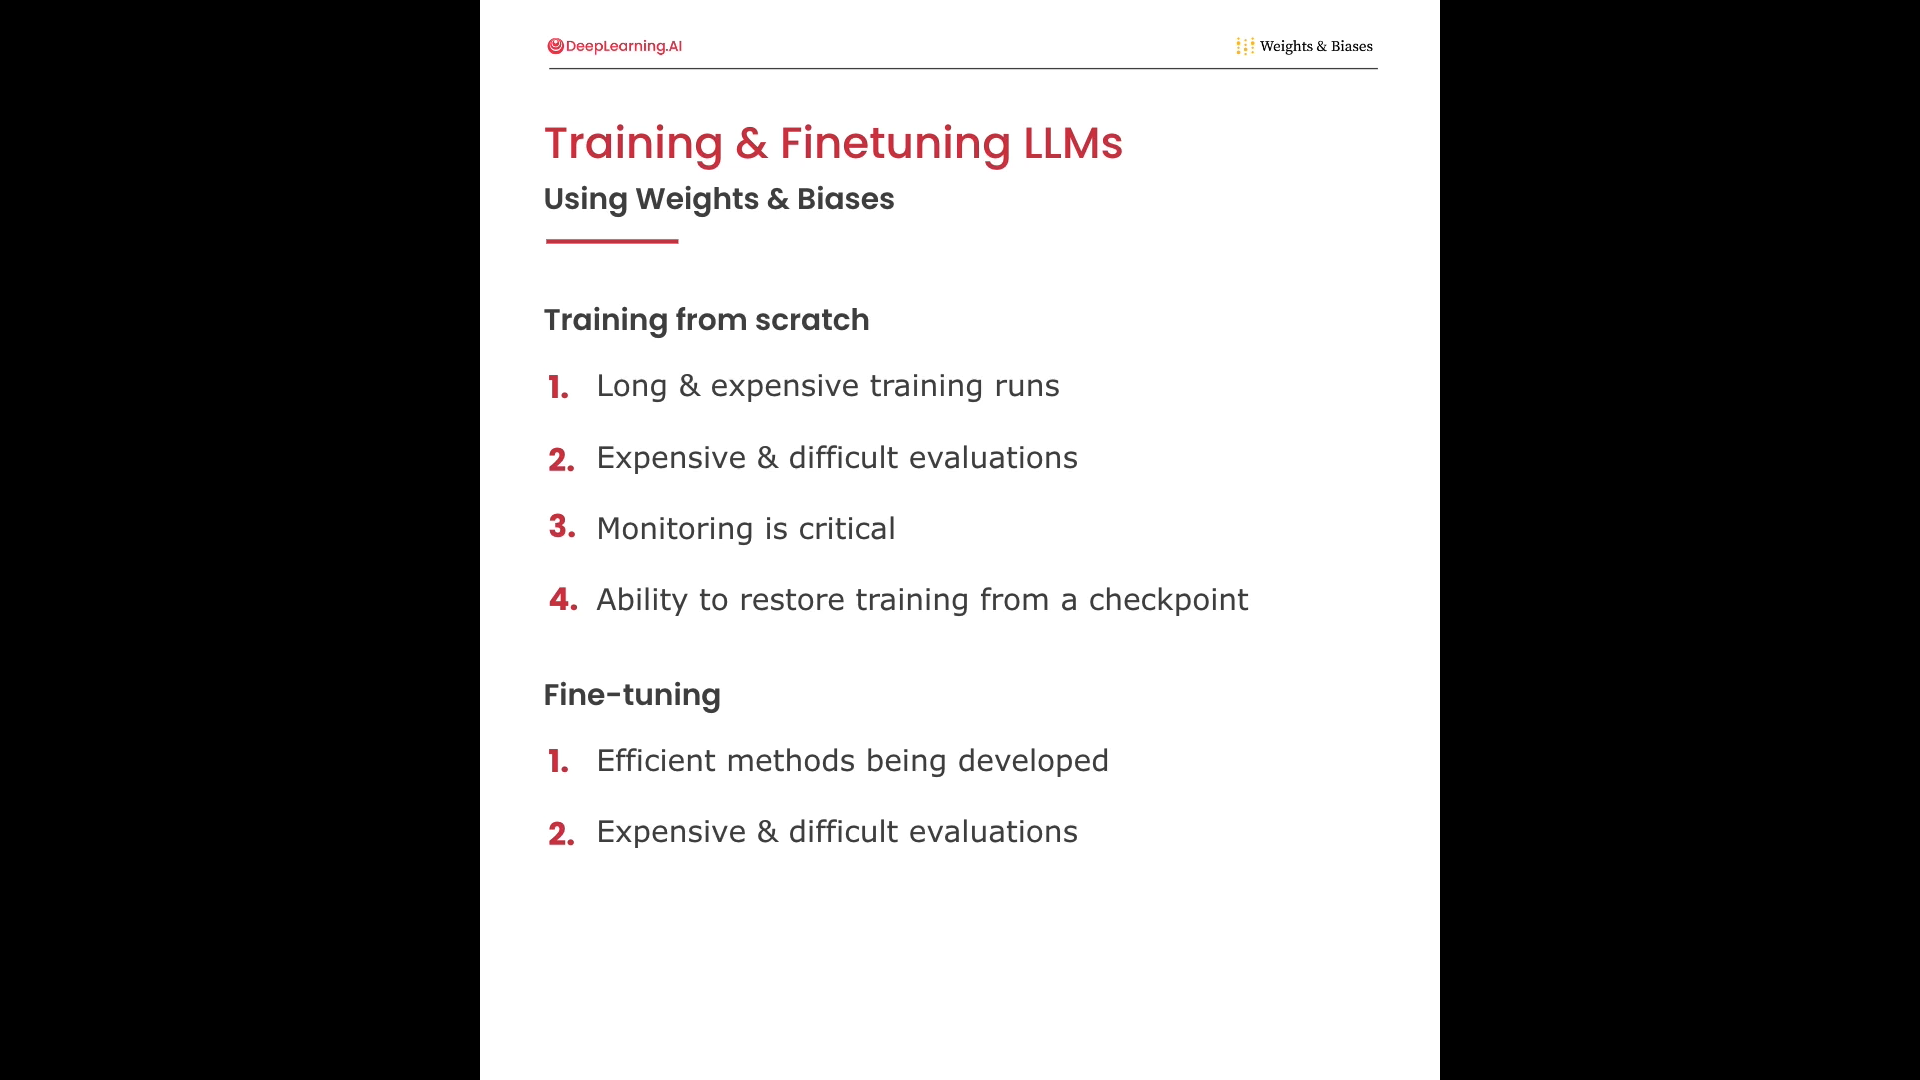

In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import AutoModelForCausalLM
from transformers import Trainer, TrainingArguments
import transformers
transformers.set_seed(42)

import wandb

wandb.login(anonymous="allow")

model_checkpoint = "roneneldan/TinyStories-33M"

### Preparing data

We'll start by loading a dataset containing Dungeons and Dragons character biographies from Huggingface. 

In [ ]:
ds = load_dataset('MohamedRashad/characters_backstories')
# Let's take a look at one example
ds["train"][400]

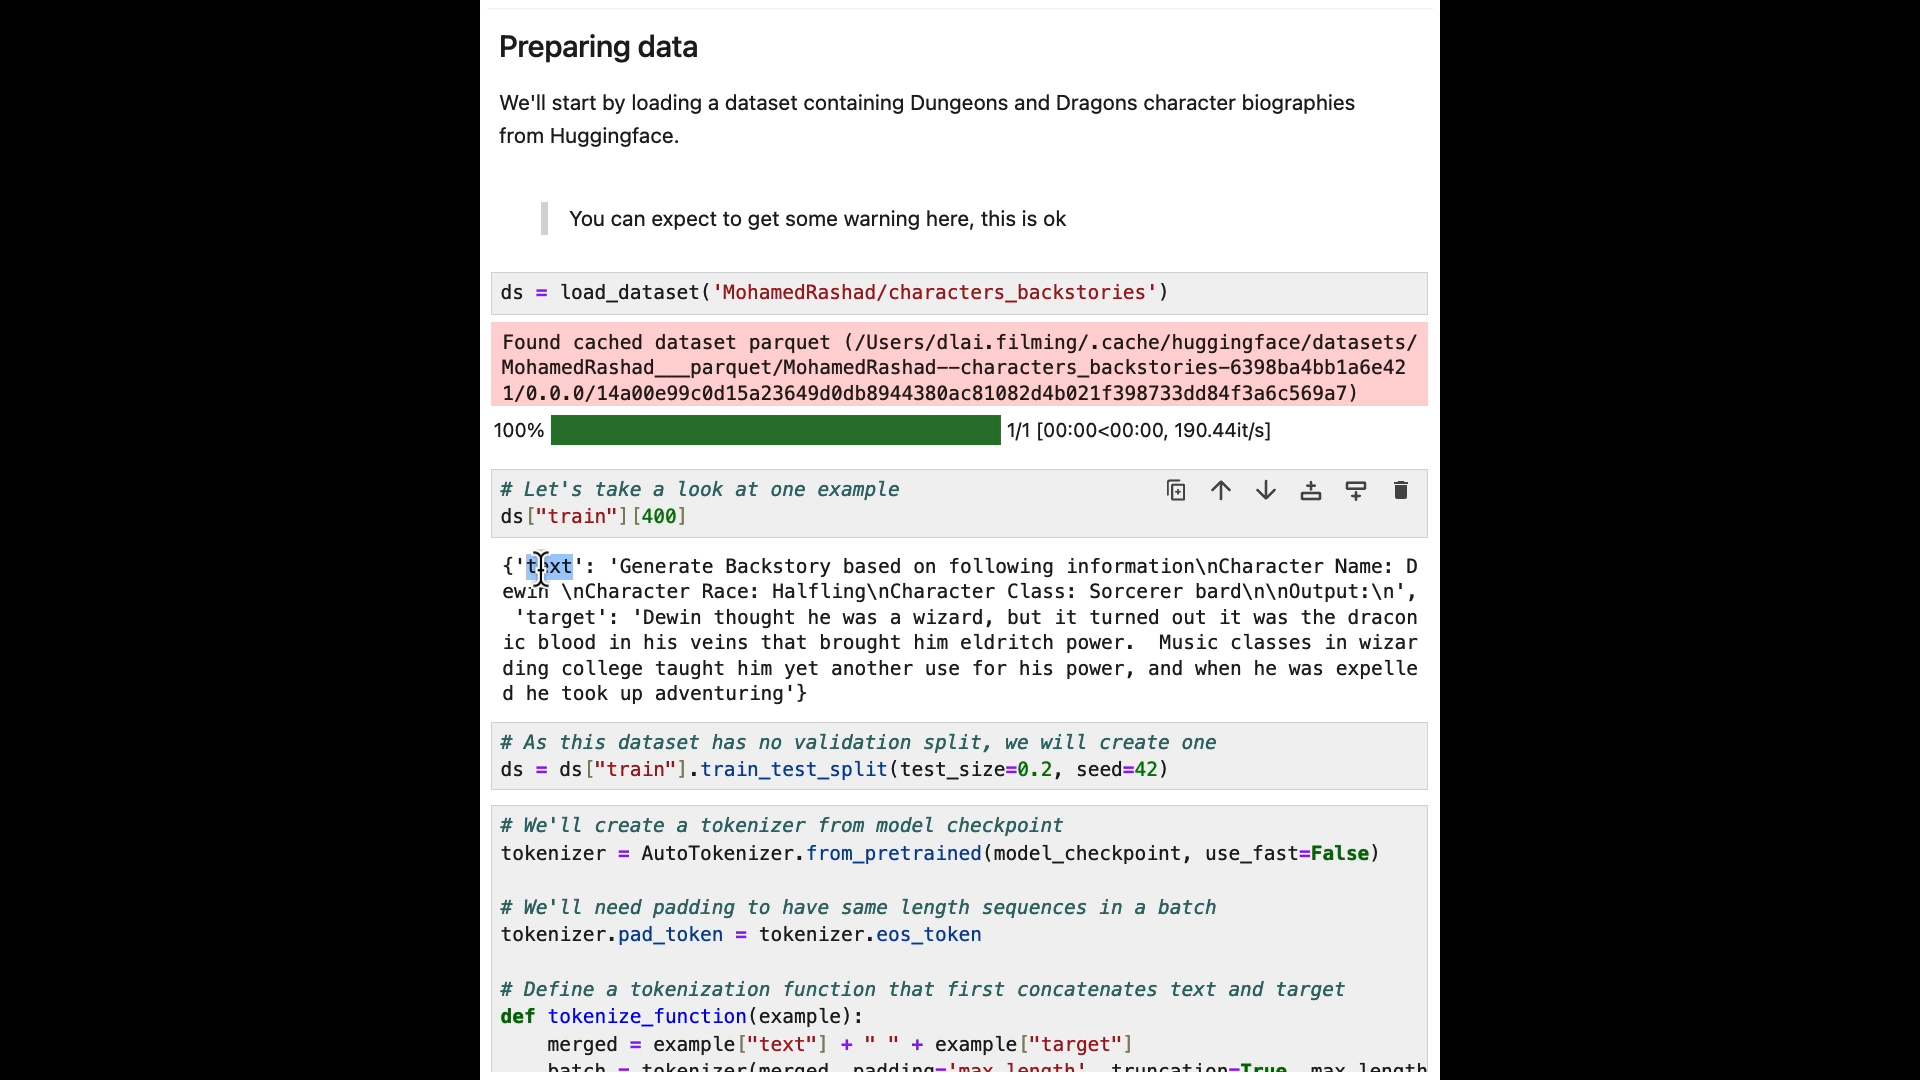

In [ ]:
# As this dataset has no validation split, we will create one
ds = ds["train"].train_test_split(test_size=0.2, seed=42)

# We'll create a tokenizer from model checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)

# We'll need padding to have same length sequences in a batch
tokenizer.pad_token = tokenizer.eos_token

# Define a tokenization function that first concatenates text and target
def tokenize_function(example):
    merged = example["text"] + " " + example["target"]
    batch = tokenizer(merged, padding='max_length', truncation=True, max_length=128)
    batch["labels"] = batch["input_ids"].copy()
    return batch

# Apply it on our dataset, and remove the text columns
tokenized_datasets = ds.map(tokenize_function, remove_columns=["text", "target"])

# Let's check out one prepared example
print(tokenizer.decode(tokenized_datasets["train"][900]['input_ids']))

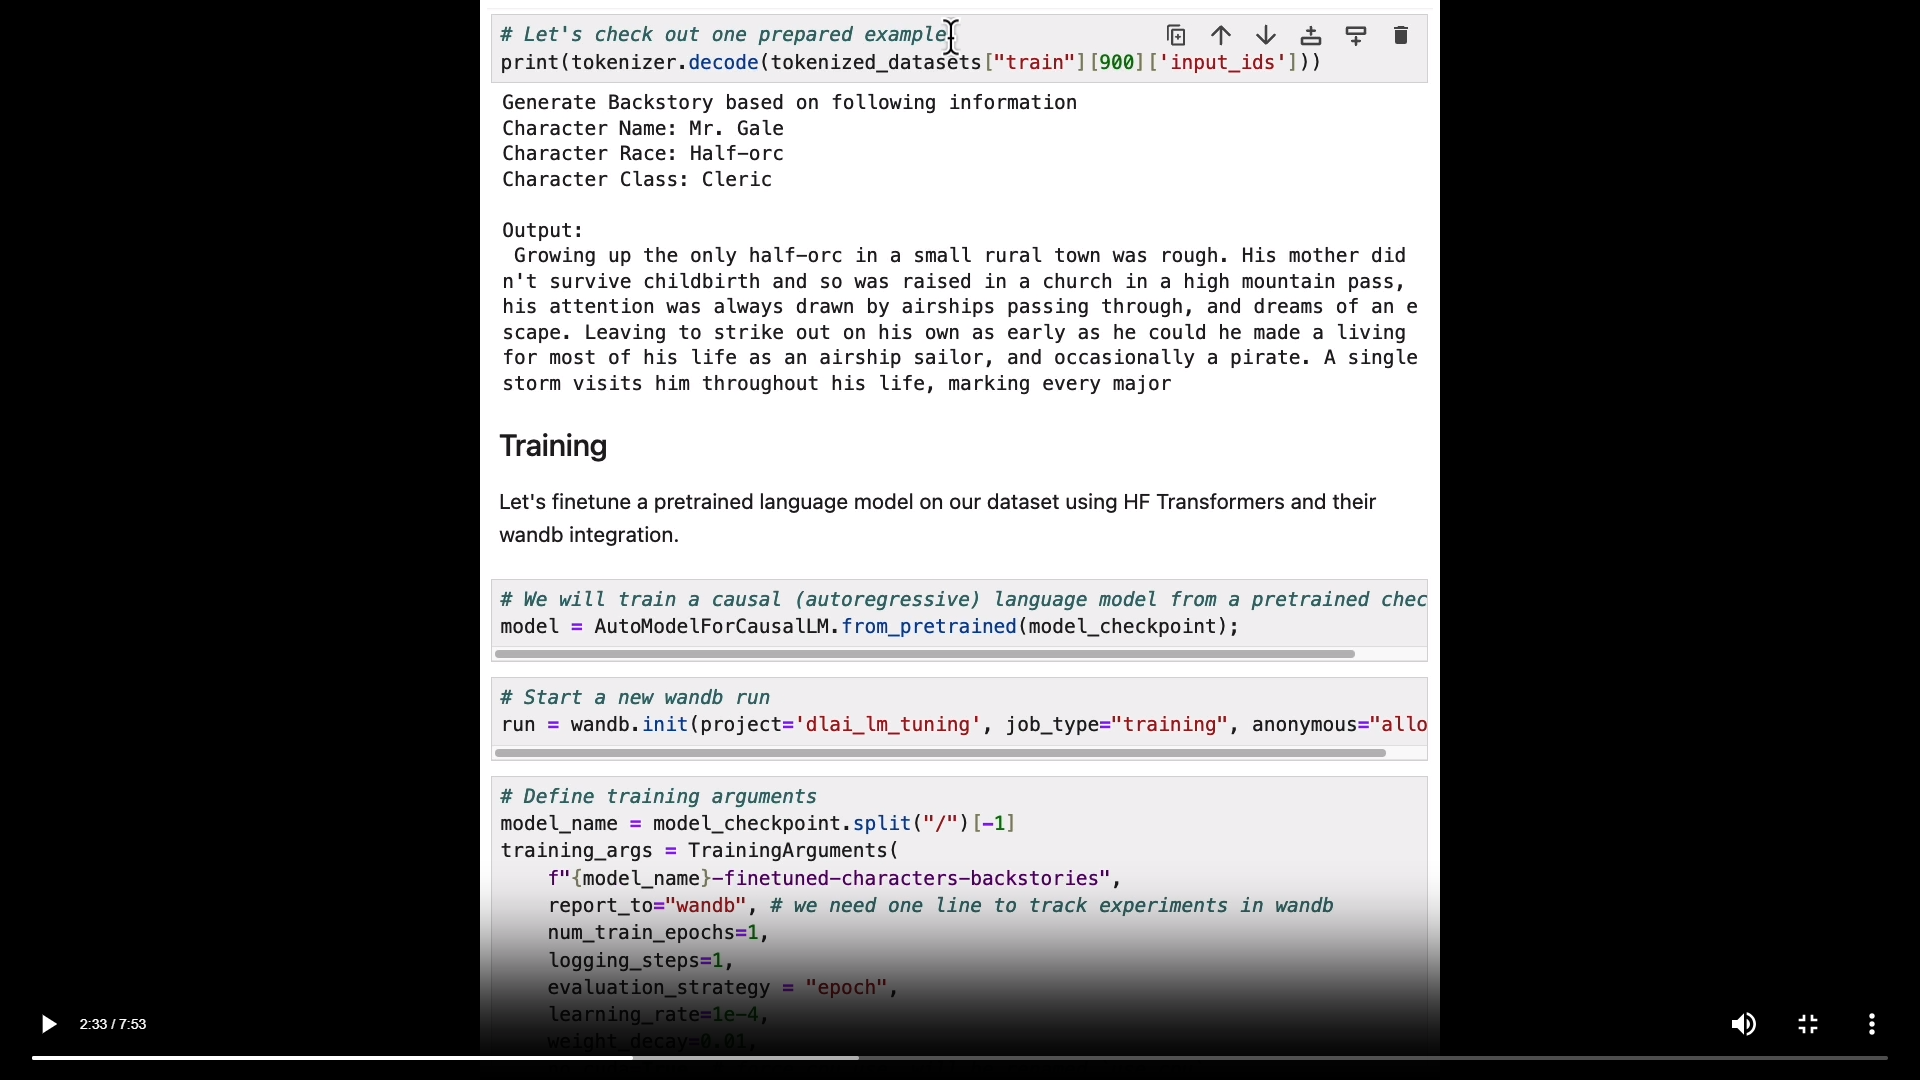

### Training
Let's finetune a pretrained language model on our dataset using HF Transformers and their wandb integration. 

In [ ]:
# We will train a causal (autoregressive) language model from a pretrained checkpoint
model = AutoModelForCausalLM.from_pretrained(model_checkpoint);

# Start a new wandb run
run = wandb.init(project='dlai_lm_tuning', job_type="training", anonymous="allow")

# Define training arguments
model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-characters-backstories",
    report_to="wandb", # we need one line to track experiments in wandb
    num_train_epochs=1,
    logging_steps=1,
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    weight_decay=0.01,
    no_cuda=True, # force cpu use, will be renamed `use_cpu`
)

# We'll use HF Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

# Let's train!
trainer.train()


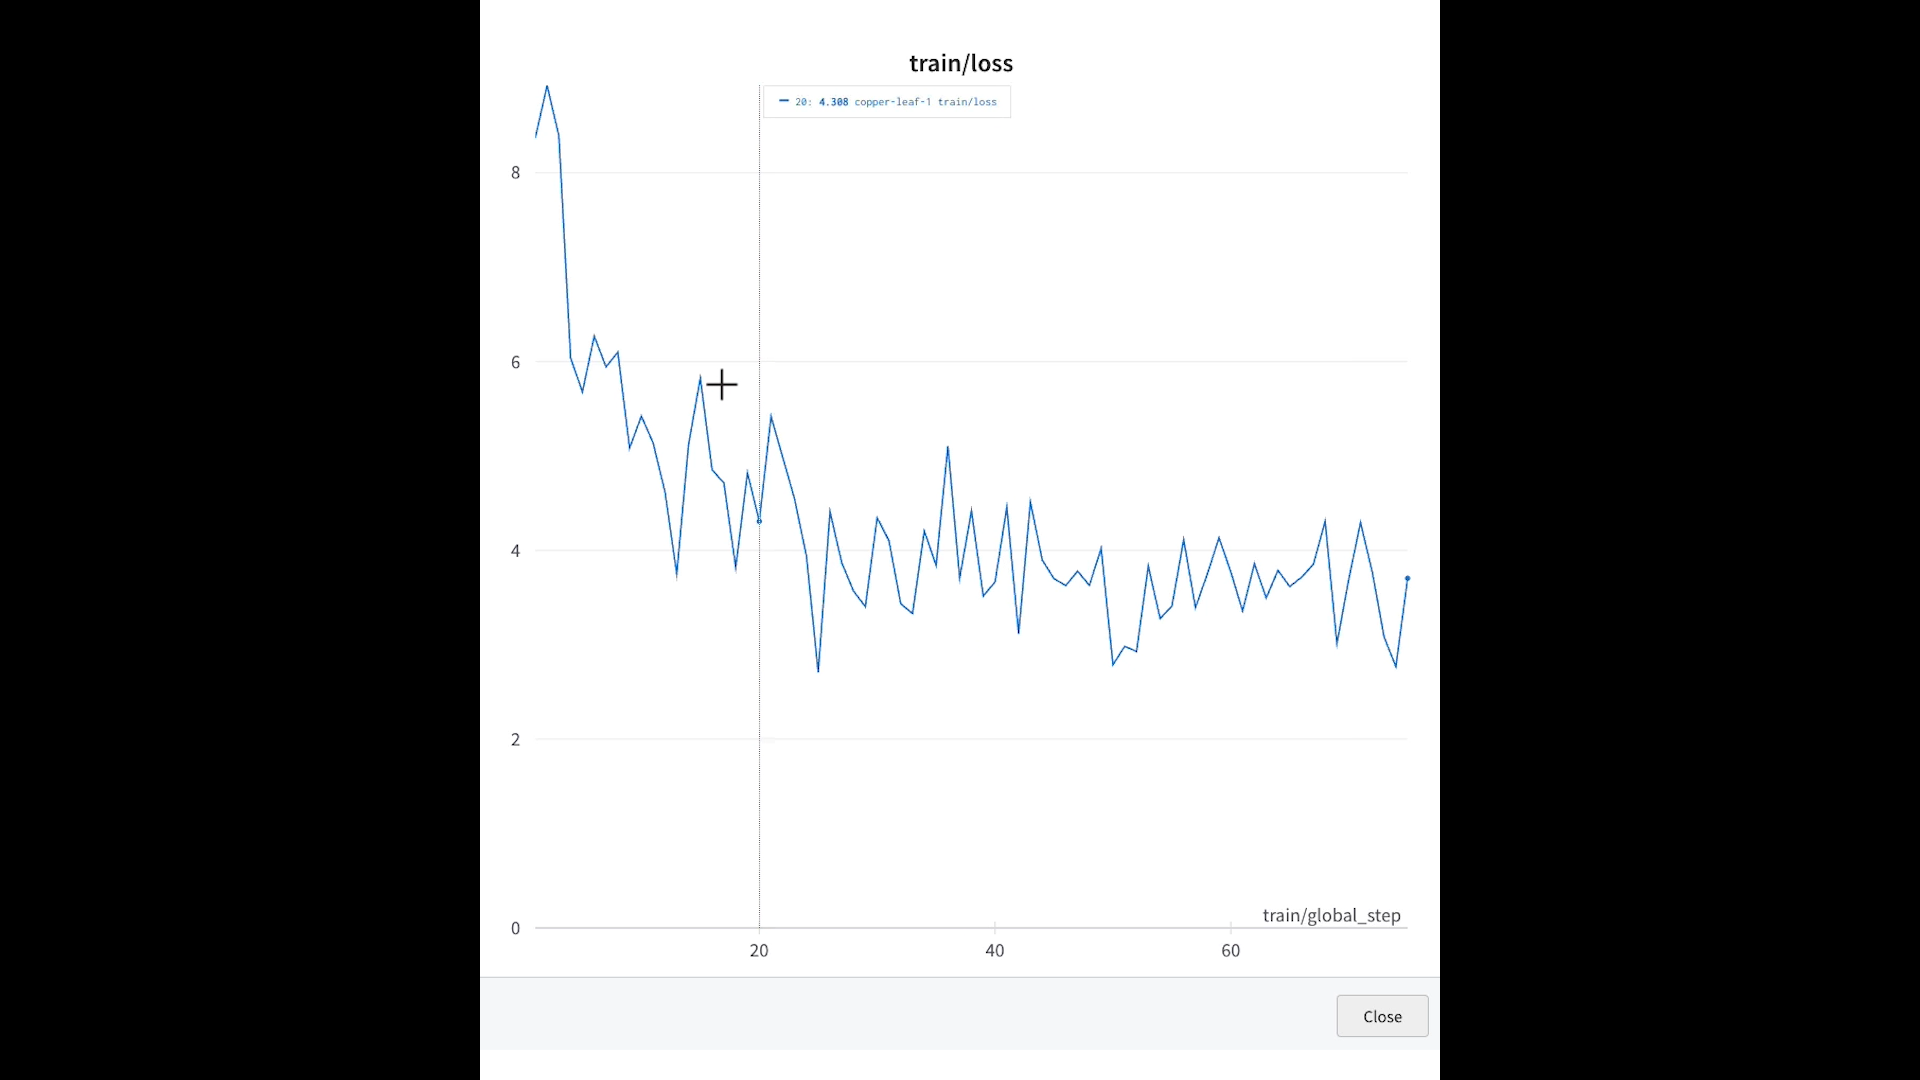

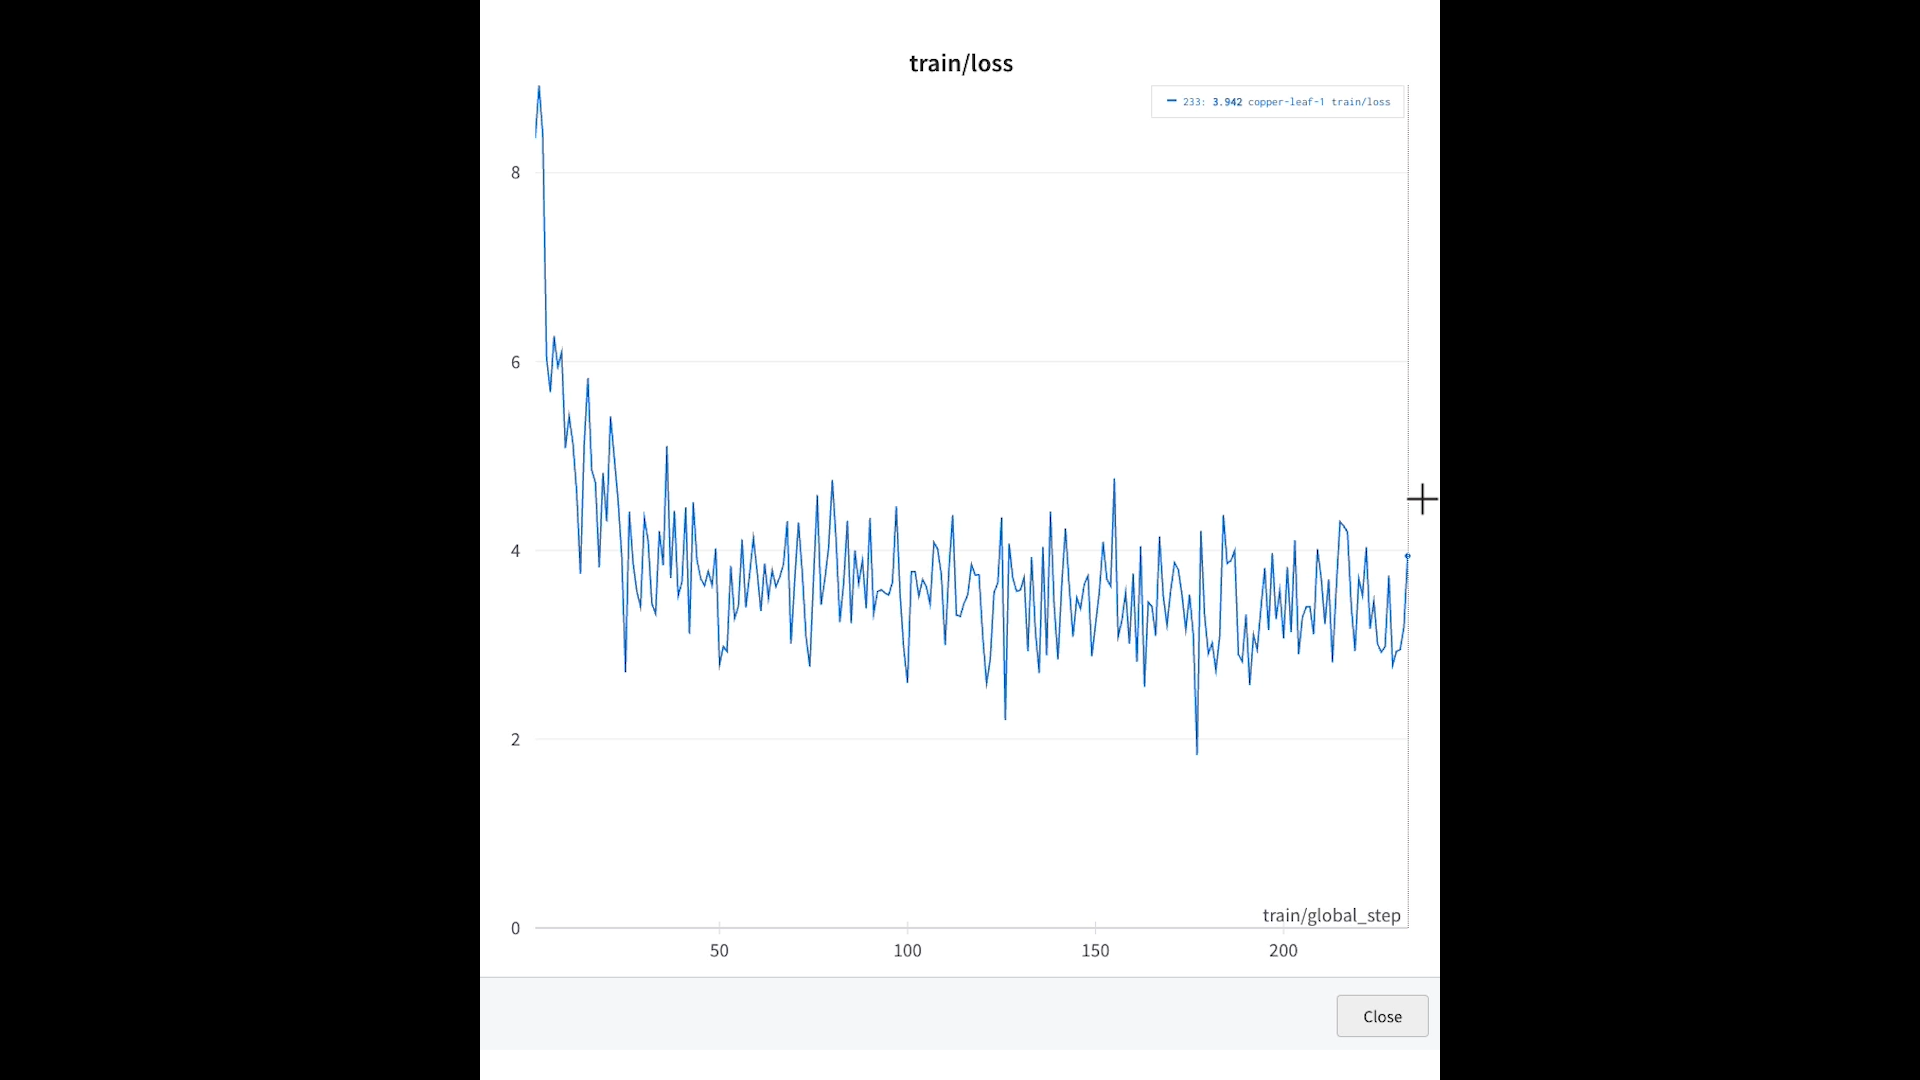

In [ ]:
transformers.logging.set_verbosity_error() # suppress tokenizer warnings

prefix = "Generate Backstory based on following information Character Name: "

prompts = [
    "Frogger Character Race: Aarakocra Character Class: Ranger Output: ",
    "Smarty Character Race: Aasimar Character Class: Cleric Output: ",
    "Volcano Character Race: Android Character Class: Paladin Output: ",
]

table = wandb.Table(columns=["prompt", "generation"])

for prompt in prompts:
    input_ids = tokenizer.encode(prefix + prompt, return_tensors="pt")
    output = model.generate(input_ids, do_sample=True, max_new_tokens=50, top_p=0.3)
    output_text = tokenizer.decode(output[0], skip_special_tokens=True)
    table.add_data(prefix + prompt, output_text)
    
wandb.log({'tiny_generations': table})


wandb.finish()

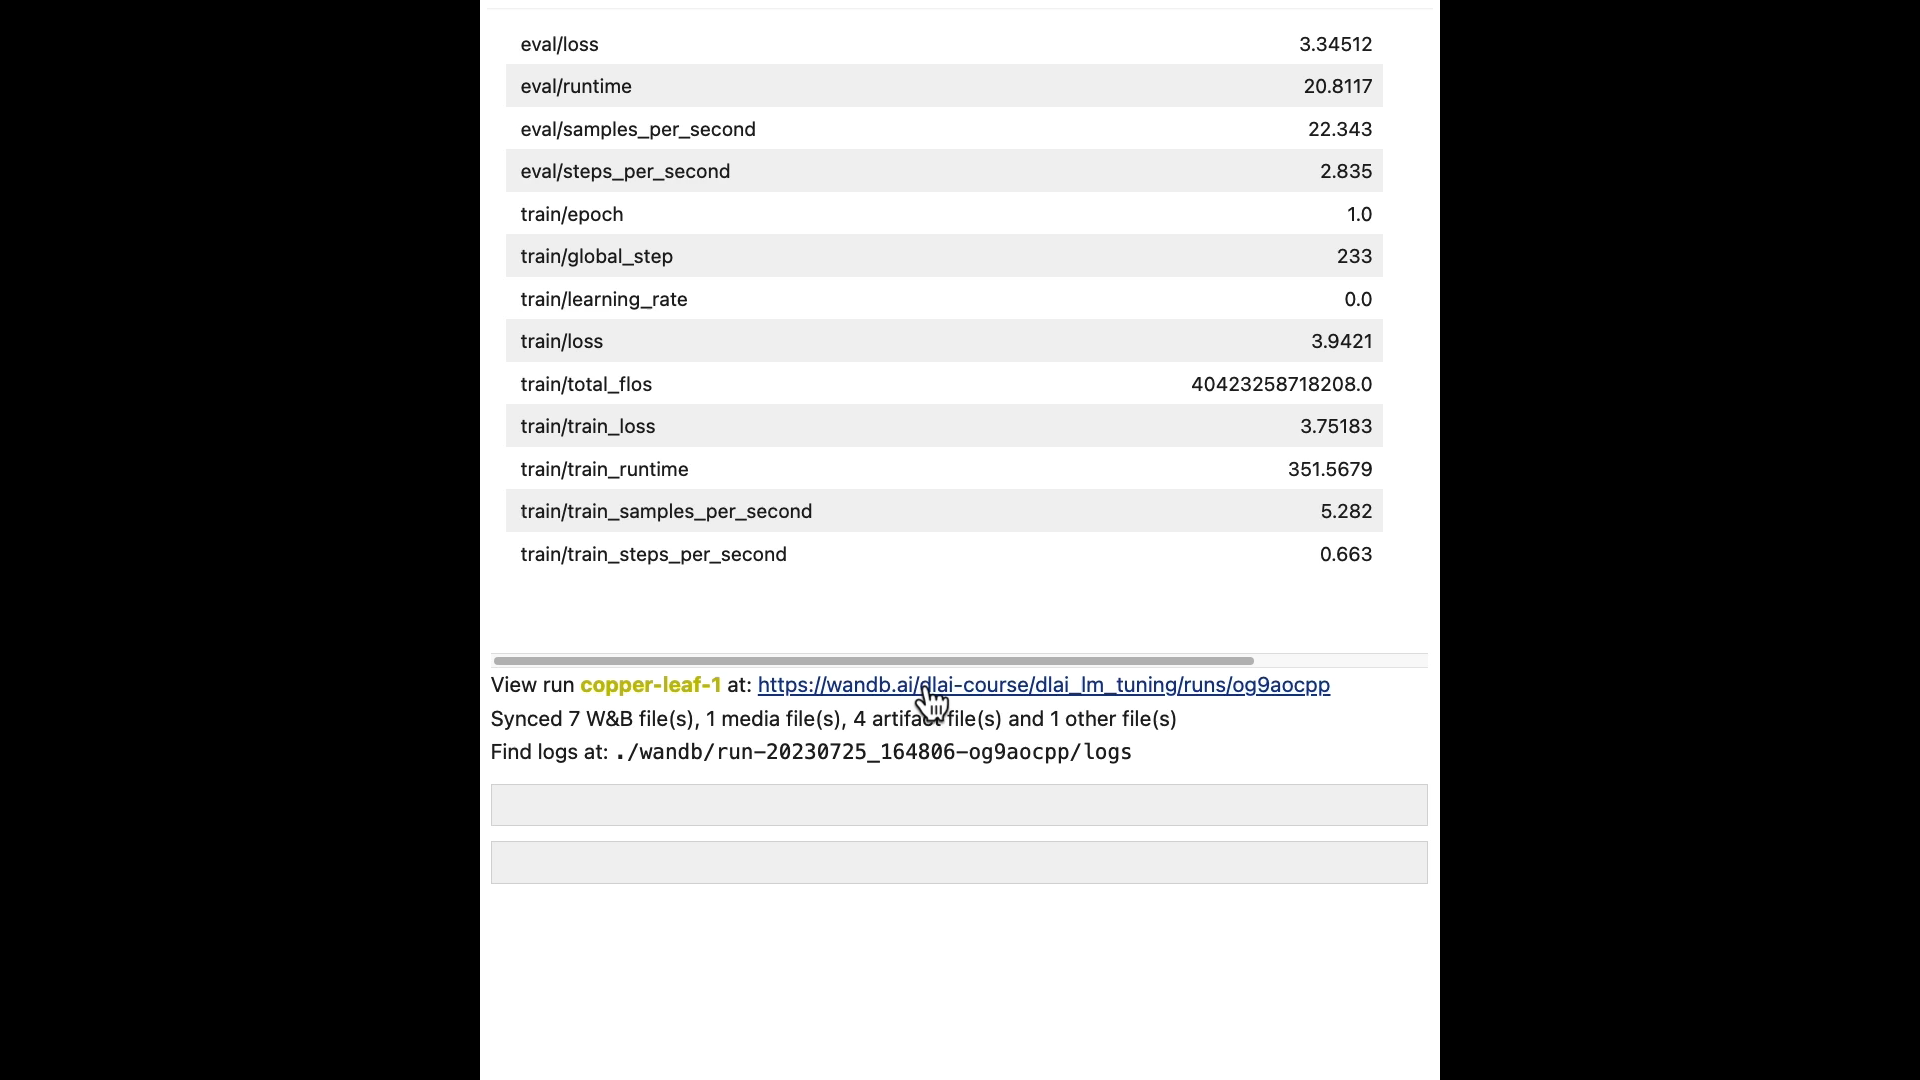

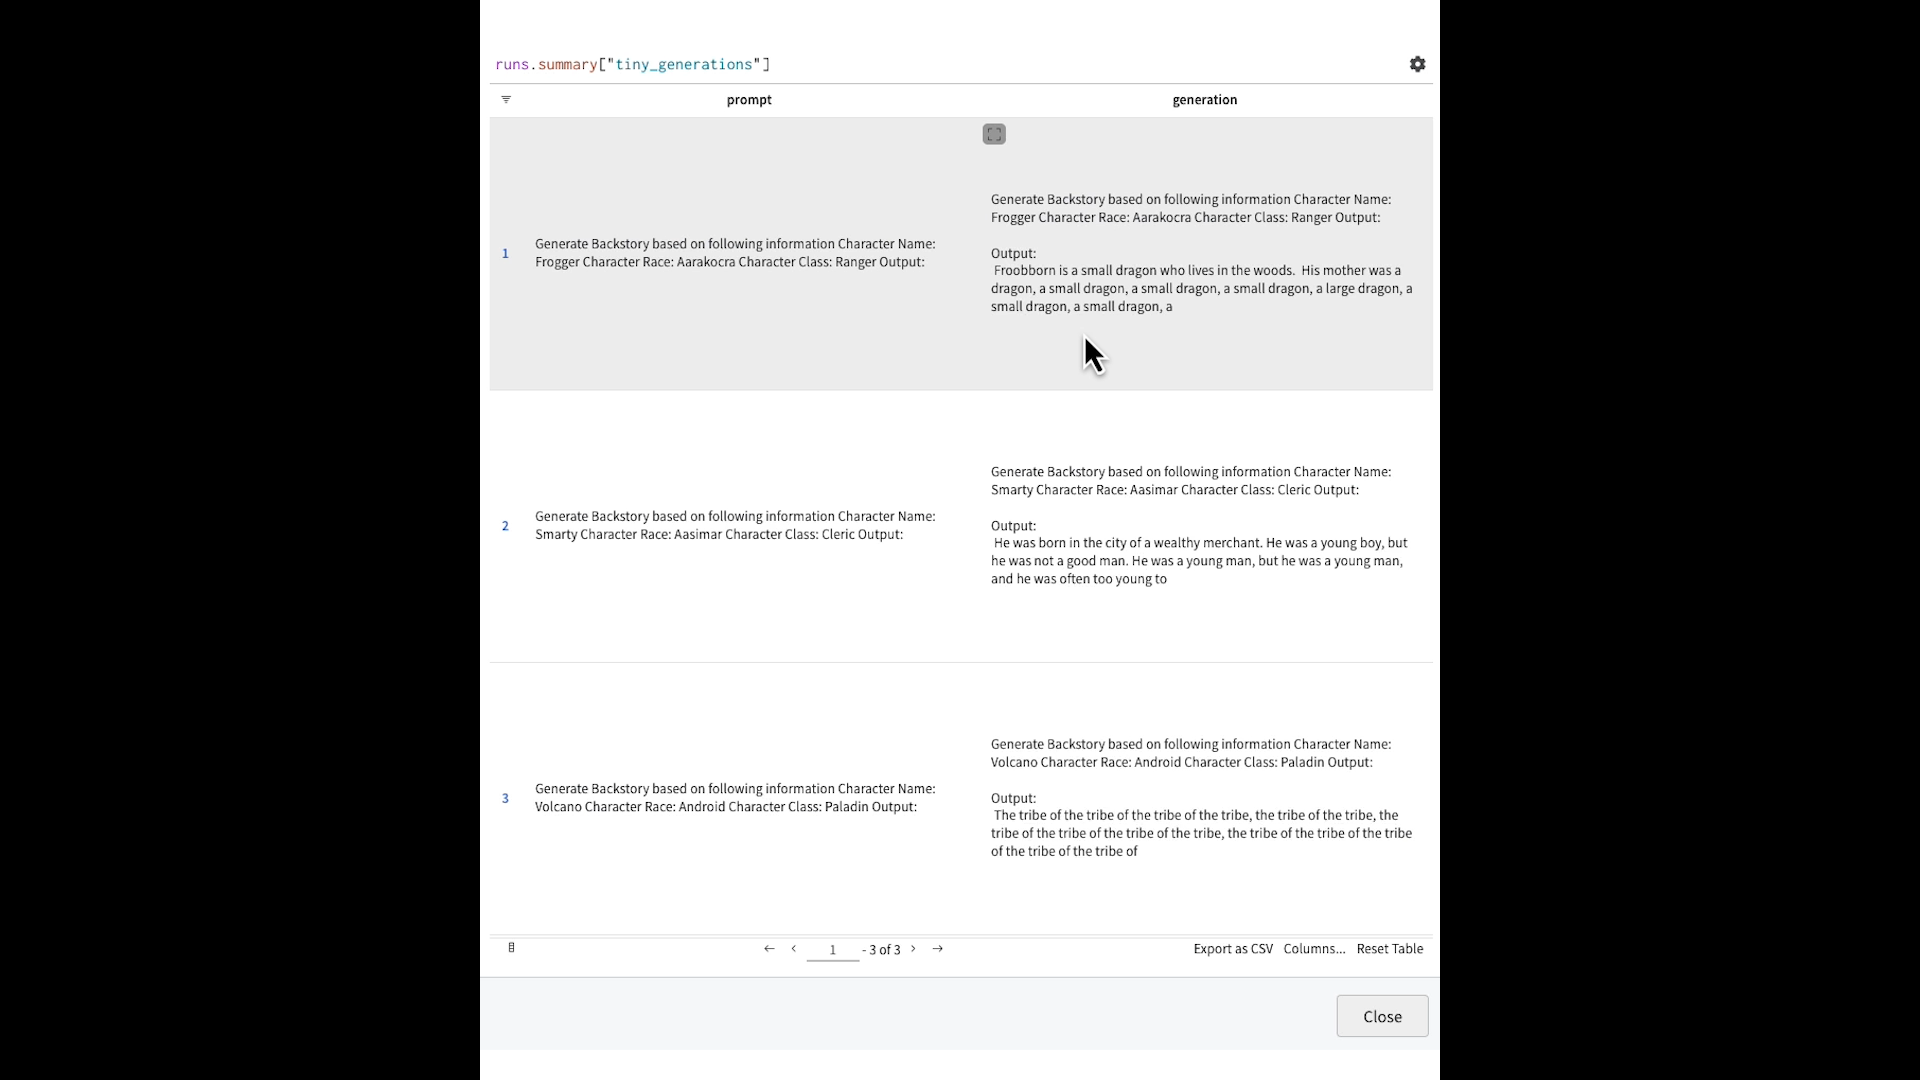